In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 星空マップ作成

## モデルを実装

In [3]:
# 日本全土のNO2,CO,夜間光、標高データ
test = pd.read_pickle('data3.pickle')

# 令和１年の約400地点のキレイ度とNO2,CO,夜間光、標高データ
train = pd.read_pickle('result_R1.pickle')

In [4]:
# 欠損値を適当な数字で埋める
test['light'] = test['light'].fillna(5)
test['NO2'] = test['NO2'].fillna(700)
test['CO'] = test['CO'].fillna(350000)

In [5]:
# Box-Cox変換
from scipy import stats as st

train['NO2']=st.boxcox( train['NO2'], lmbda = -2)
test['NO2']=st.boxcox( test['NO2'], lmbda = -2)

test['標高'] = test['標高'].map(lambda x: 0.1 if x<=0 else x)
train['標高']=st.boxcox( train['標高'], lmbda = 0.3)
test['標高']=st.boxcox( test['標高'], lmbda = 0.3)

test.drop(['緯度','経度'], axis=1, inplace=True)
train.drop(['都道府県'],axis=1, inplace=True)

In [6]:
X_train = train.drop(['キレイ度'], axis=1)
y_train = train['キレイ度']

In [7]:
import xgboost as xgb

model = xgb.XGBRegressor(booster = 'gbtree',
                         objective = 'reg:linear',
                         eval_metric = 'rmse',
                         random_staate=100,
                         learning_rate=0.09,
                         n_estimators= 135,
                         max_depth = 1,
                         min_child_weight = 1,
                         colsample_bytree = 1)

model.fit(X_train, y_train)
y_pred = model.predict(test)

print(model.score(X_train,y_train))

[17:47:15] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:47:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "random_staate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.8099667733479186


In [8]:
test=pd.read_pickle('data3.pickle')
map2 = pd.DataFrame([y_pred, test['緯度'], test['経度']]).T

In [9]:
map2.columns = ['キレイ度','経度','緯度']

In [43]:
map2

,キレイ度,経度,緯度
0,20.916517,123.750000,24.447150
1,21.043055,123.750000,24.407138
2,21.493176,123.750000,24.367114
3,21.223362,123.750000,24.327077
4,21.493176,123.750000,24.287027
...,...,...,...
28371,21.159508,148.842773,45.490946
28372,21.106068,148.842773,45.429299
28373,21.159508,148.842773,45.398450
28374,20.955267,148.842773,45.367584


C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 32239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 32076 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\umeyu\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 32239 missing from curre

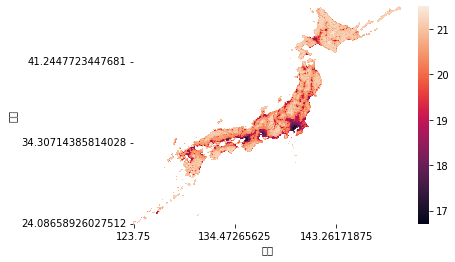

In [12]:
import seaborn as sns

df_flights_pivot2 = pd.pivot_table(data=map2, values='キレイ度', 
                                  columns='経度', index='緯度', aggfunc=np.mean)

ax2 = sns.heatmap(df_flights_pivot2, xticklabels=200, yticklabels=200)
ax2.invert_yaxis()

In [ ]:
map2.to_pickle('data4.pickle')

## geojsonファイルを作成

In [41]:
# 日本全土のキレイ度と緯度経度データ
data = pd.read_pickle('data4.pickle')

In [91]:
data

,キレイ度,経度,緯度
0,20.804956,123.750000,24.447150
1,20.981321,123.750000,24.407138
2,21.637159,123.750000,24.367114
3,21.106865,123.750000,24.327077
4,21.637159,123.750000,24.287027
...,...,...,...
33,20.682028,139.965820,39.943436
34,20.257517,140.009766,40.078071
35,20.506737,140.009766,40.044438
36,20.506737,140.009766,40.010787


In [92]:
ido = data['緯度']
keido = data['経度']
kirei = data['キレイ度']

In [93]:
# 行を緯度、列を経度にしたからのデータフレームを作成
b = [[0.0]*len(keido.unique())]*len(ido.unique())
a = pd.DataFrame(b)
a.index = np.sort(ido.unique())[::-1]
a.columns = np.sort(keido.unique())

In [94]:
# 空のデータフレームにキレイ度を入れる
from tqdm.notebook import tqdm

for x, y, c in tqdm(zip(ido, keido, kirei)):
    a.loc[x][y]=c

0it [00:00, ?it/s]

In [96]:
old_col = a.columns

In [97]:
# マップの謎のずれ修正
new_col = []

for i, col in enumerate(old_col):
    if i != 0:
        new_col.append(col)

In [98]:
new_col.append(new_col[-1]-new_col[-2]+new_col[-1])

In [99]:
a.columns = new_col

In [101]:
# 点データを面データに変換
k = a.columns
j = a.index
geo = []
pro = []

for i in tqdm(range(len(k)-1)):
    for z in range(len(j)-1):
        
        my = a[k[i]][j[z]]
        down = a[k[i]][j[z+1]]
        right = a[k[i+1]][j[z]]
        dr = a[k[i+1]][j[z+1]]

        l = []
        if my != 0:
            l.append([k[i], j[z]])
        if right != 0:
            l.append([k[i+1], j[z]])
        if dr != 0:
            l.append([k[i+1], j[z+1]])
        if down != 0:
            l.append([k[i], j[z+1]])
        
        v = (down + right + dr + my)/len(l)

        if len(l)>=3:
            geo.append(l)
            pro.append(v)

  0%|          | 0/528 [00:00<?, ?it/s]

C:\Users\umeyu\AppData\Local\Temp/ipykernel_11156/773245935.py:25: RuntimeWarning: invalid value encountered in double_scalars
  v = (down + right + dr + my)/len(l)


In [103]:
# geojsonファイルを作成
import csv, json
from geojson import Feature, FeatureCollection, Polygon

features = []

for g, c in zip(geo, pro):
    features.append(
        Feature(
            geometry = Polygon([g]),
            properties = {
                'clean': c
            }
        )
    )

collection = FeatureCollection(features)
with open("data_polygon3.json", "w") as f:
    f.write('%s' % collection)